In [1]:
import scqubits
import qutip


In [2]:
import math
import numpy as np
def generate_single_mapping(H_with_interaction_no_drive,
                            OVERLAP_THRESHOLD = 0) -> np.ndarray:
    """
    Returns a dictionary like {(0,0,0):0,(0,0,1):1}
    I use this function because I can adjust the OVERLAP_THRESHOLD.
    """
    evals, evecs = H_with_interaction_no_drive.eigenstates()
    overlap_matrix = scqubits.utils.spectrum_utils.convert_evecs_to_ndarray(evecs)
    product_state_names = []
    dims = H_with_interaction_no_drive.dims[0]
    system_size = len(dims)
    def generate_product_states(current_state, ele_index):
        if ele_index == system_size:
            product_state_names.append(tuple(current_state))
            return
        
        for l in range(dims[ele_index]):
            current_state[ele_index] = l
            generate_product_states(current_state.copy(), ele_index + 1)

    current_state = [0] * system_size
    generate_product_states(current_state, 0)



    total_dim = math.prod(dims)
    dressed_indices_and_overlap = [None] * total_dim
    for dressed_index in range(len(evals)):
        max_position = (np.abs(overlap_matrix[dressed_index, :])).argmax()
        max_overlap = np.abs(overlap_matrix[dressed_index, max_position])
        if (max_overlap**2 > OVERLAP_THRESHOLD):
            overlap_matrix[:, max_position] = 0
            dressed_indices_and_overlap[int(max_position)] = (dressed_index,max_overlap**2)
        else:
            print(f'max overlap^2 {max_overlap**2} below threshold for dressed state {dressed_index} with eval {evals[dressed_index]}')
    product_to_dressed = {}
    product_to_overlap = {}
    for product, dressed_and_overlap in zip(product_state_names,dressed_indices_and_overlap):
        product_to_dressed[product] = dressed_and_overlap[0]
        product_to_overlap[product] = dressed_and_overlap[1]
    return product_to_dressed,product_to_overlap

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

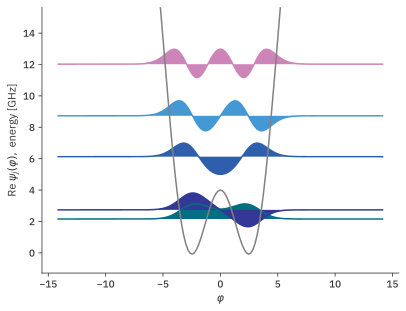

In [11]:
# EJ = 8.4
# EC = 3.4
# EL = 1.2

# EJ = 5.5
# EC = 1.5
# EL = 1

EJ = 4
EC = 1
EL = 1
molecule_coupling = 0.2
flux_ext = 0.5
g = 0.1

osc_frequency = 9.2

assymetry = 0.00

flux_1 = (2+assymetry)/2*flux_ext
flux_2 = (2-assymetry)/2*flux_ext

qubit_levels = 5
osc_levels = 3



qubit1 = scqubits.Fluxonium(EJ = EJ,
                    EC =EC,
                    EL = EL,
                    flux = flux_1,
                    cutoff = 110,
                    truncated_dim = qubit_levels)
qubit2 = scqubits.Fluxonium(EJ = EJ,
                    EC =EC,
                    EL = EL,
                    flux = flux_2,
                    cutoff = 110,
                    truncated_dim = qubit_levels)

osc = scqubits.Oscillator(
    E_osc = osc_frequency,
    l_osc = 1,
    truncated_dim=osc_levels
)

####################################
# molecule + osc
####################################

hilbertspace = scqubits.HilbertSpace([qubit1,qubit2, osc])

hilbertspace.add_interaction(
    g_strength=molecule_coupling, op1=qubit1.phi_operator, op2=qubit2.phi_operator, add_hc=False
)

hilbertspace.add_interaction(
   qobj = -EL/6* qutip.tensor(qutip.Qobj((qutip.Qobj(qubit1.phi_operator(energy_esys  = False))**2)[:qubit1.truncated_dim, :qubit1.truncated_dim]),
                                qutip.identity(dims = qubit2.truncated_dim),
                                qutip.identity(dims = osc.truncated_dim))
)
hilbertspace.add_interaction(
   qobj = -EL/6* qutip.tensor(qutip.identity(dims = qubit1.truncated_dim),
                                qutip.Qobj((qutip.Qobj(qubit2.phi_operator(energy_esys  = False))**2)[:qubit2.truncated_dim, :qubit2.truncated_dim]),
                                qutip.identity(dims = osc.truncated_dim))
)

hilbertspace.add_interaction(
    g_strength=g, op1=qubit1.n_operator, op2=osc.creation_operator, add_hc=True
)

hilbertspace.add_interaction(
    g_strength=g, op1=qubit2.n_operator, op2=osc.creation_operator, add_hc=True
)
hilbertspace.generate_lookup()

####################################
# molecule alone
####################################


molecule = scqubits.HilbertSpace([qubit1,qubit2])

molecule.add_interaction(
    g_strength=molecule_coupling, op1=qubit1.phi_operator, op2=qubit2.phi_operator, add_hc=False
)

molecule.add_interaction(
   qobj = -EL/6* qutip.tensor(qutip.Qobj((qutip.Qobj(qubit1.phi_operator(energy_esys  = False))**2)[:qubit1.truncated_dim, :qubit1.truncated_dim]),
                                qutip.identity(dims = qubit2.truncated_dim))
)
molecule.add_interaction(
   qobj = -EL/6* qutip.tensor(qutip.identity(dims = qubit1.truncated_dim),
                                qutip.Qobj((qutip.Qobj(qubit2.phi_operator(energy_esys  = False))**2)[:qubit2.truncated_dim, :qubit2.truncated_dim]))
)
molecule.generate_lookup()


qubit1.plot_wavefunction(which=[0,1,2,3,4])

# Plot the un-driven, dressed levels

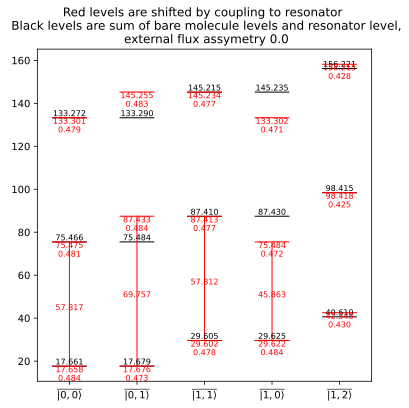

In [12]:
import matplotlib.pyplot as plt
from bidict import bidict
def plot_specturum(molecule, osc,hilbertspace):
    energy_text_size = 8
    max_molecule_level = 5
    max_resonator_level = 3
    bare_color = 'black'
    dressed_color = 'red'

    molecule_evals = molecule.hamiltonian().eigenenergies()
    hilbertspace_evals = hilbertspace.hamiltonian().eigenenergies()
    osc_evals = osc.eigenvals(max_resonator_level)

    qls_to_ml,qls_to_overlap = generate_single_mapping(molecule.hamiltonian())
    qls_to_ml = bidict(qls_to_ml)
    qlqlrl_to_dressed_level, qlqlrl_to_overlap = generate_single_mapping(hilbertspace.hamiltonian())
    qlqlrl_to_dressed_level = bidict(qlqlrl_to_dressed_level)

    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    for ml in range(0,max_molecule_level):
        for rl in range(0,max_resonator_level):
            ##################################################################
            # 1 plot molecule + osc bare levels 
            ##################################################################
            # get energy
            original = (molecule_evals[ml] + osc_evals[rl])* 2 * np.pi

            # draw line, x axis being the molecule level
            x1,x2 = ml-0.25,ml+0.25
            ax.plot([x1, x2], [original, original], linewidth=1, color=bare_color)
            ax.text(ml, original, f"{original:.3f}", fontsize=energy_text_size, ha='center', va='bottom',color=bare_color)
            ##################################################################
            # 2 plot molecule + osc dressed levels 
            ##################################################################
            dressed_index = qlqlrl_to_dressed_level[(qls_to_ml.inverse[ml][0],qls_to_ml.inverse[ml][1],rl)]
            overlap = qlqlrl_to_overlap[(qls_to_ml.inverse[ml][0],qls_to_ml.inverse[ml][1],rl)]
            dressed_energy = hilbertspace_evals[dressed_index]* 2 * np.pi
            ax.plot([x1, x2], [dressed_energy, dressed_energy], linewidth=1, color=dressed_color)
            ax.text(ml, dressed_energy-4, f"{overlap:.3f}", fontsize=energy_text_size, ha='center', va='top', color=dressed_color)
            ax.text(ml, dressed_energy, f"{dressed_energy:.3f}", fontsize=energy_text_size, ha='center', va='top', color=dressed_color)


    ##################################################################
    # 3 plot dressed transitions 000-001, 010-011, 100-101 and 110-111
    ##################################################################
    for transition in [[(0,0,0),(0,0,1)],[(0,1,0),(0,1,1)],[(1,0,0),(1,0,1)],[(1,1,0),(1,1,1)]]:
        state1, state2 = transition[0],transition[1]
        dressed_index1 = qlqlrl_to_dressed_level[(state1[0],state1[1],state1[2])]
        dressed_index2 = qlqlrl_to_dressed_level[(state2[0],state2[1],state2[2])]
        energy1 = hilbertspace_evals[dressed_index1]* 2 * np.pi
        energy2 = hilbertspace_evals[dressed_index2]* 2 * np.pi
        ml1 = qls_to_ml[(state1[0],state1[1])]
        ml2 = qls_to_ml[(state2[0],state2[1])]
        ax.plot([ml1, ml2], [energy1, energy2], linewidth=1, color=dressed_color)
        ax.text((ml1+ ml2)/2, (energy1+ energy2)/2, f"{energy2-energy1:.3f}", fontsize=energy_text_size, ha='center', va='top', color=dressed_color)

    x = list(range(0,max_molecule_level))
    ticks = [r"$\overline{|%s\rangle}$" % str(",".join([str(item) for item in qls_to_ml.inverse[ml]])) for ml in range(max_molecule_level)]
    plt.xticks(x, ticks)

    plt.title(f'Red levels are shifted by coupling to resonator \n Black levels are sum of bare molecule levels and resonator level,\n external flux assymetry {assymetry}')
    plt.show()


plot_specturum(molecule, osc,hilbertspace)


# Add drive and evolve

In [17]:
a = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator)

a = qutip.Qobj(a[:, :])# We work in energy eigenbasis, thus not using tensor products

(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian = (
        2 * np.pi * qutip.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)
diag_dressed_hamiltonian = qutip.Qobj(diag_dressed_hamiltonian[:, :])

def transition_frequency(s0: int, s1: int) -> float:
    return abs(
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )


qlqlrl_to_dressed_level, qlqlrl_to_overlap = generate_single_mapping(hilbertspace.hamiltonian())
# w_d = transition_frequency(qlqlrl_to_dressed_level[(0,0,0)], qlqlrl_to_dressed_level[(0,0,1)])/2   \
#         +transition_frequency(qlqlrl_to_dressed_level[(1,1,0)], qlqlrl_to_dressed_level[(1,1,1)])/2

w_d = transition_frequency(qlqlrl_to_dressed_level[(0,0,0)], qlqlrl_to_dressed_level[(0,0,1)])


tot_time = 300

matrix_element_driven = abs((a+a.dag()).data.toarray()[qlqlrl_to_dressed_level[(0,0,0)]][qlqlrl_to_dressed_level[(0,0,1)]])/2  \
        + abs((a+a.dag()).data.toarray()[qlqlrl_to_dressed_level[(1,1,0)]][qlqlrl_to_dressed_level[(1,1,1)]])/2

A_square = 1/tot_time
A_square = A_square/matrix_element_driven


# tot_time = int(tot_time*2)
tlist = np.linspace(0, tot_time, tot_time*2)
def square_cos(t,*args):
    cos = np.cos(w_d * 2*np.pi * t)
    return  2*np.pi *A_square * cos

H_with_drive = [
    diag_dressed_hamiltonian,
    [a+a.dag(), square_cos]]



product_states = [(0, 0, 0),(0, 0, 1), (0, 1, 0), (0, 1, 1),  (1, 0, 0),  (1, 0, 1), (1, 1, 0 ), (1,1,1)]
dressed_idxs = [qlqlrl_to_dressed_level[product_indices] for product_indices in product_states]
qutip_states = [qutip.basis(hilbertspace.dimension, idx) for idx in dressed_idxs]

results = []
for dressed_idx in [qlqlrl_to_dressed_level[product_indices] for product_indices in  [(0, 0, 0),(0, 1, 0), (1, 0, 0),  (1, 1, 0 )]]:
    temp = qutip.mesolve(
        H = H_with_drive,
        rho0 = qutip.basis(hilbertspace.dimension, dressed_idx),
        tlist = tlist,
        e_ops=[state * state.dag() for state in qutip_states]+[a,
                                                               a.dag()*a,
                                                             ],
        options=qutip.Options(store_states=True,nsteps=1000),
        progress_bar =True
    )
    results.append(temp)


10.0%. Run time:   0.35s. Est. time left: 00:00:00:03
20.0%. Run time:   0.74s. Est. time left: 00:00:00:02
30.0%. Run time:   1.13s. Est. time left: 00:00:00:02
40.0%. Run time:   1.52s. Est. time left: 00:00:00:02
50.0%. Run time:   1.91s. Est. time left: 00:00:00:01
60.0%. Run time:   2.30s. Est. time left: 00:00:00:01
70.0%. Run time:   2.70s. Est. time left: 00:00:00:01
80.0%. Run time:   3.08s. Est. time left: 00:00:00:00
90.0%. Run time:   3.47s. Est. time left: 00:00:00:00
Total run time:   3.85s
10.0%. Run time:   0.35s. Est. time left: 00:00:00:03
20.0%. Run time:   0.72s. Est. time left: 00:00:00:02
30.0%. Run time:   1.11s. Est. time left: 00:00:00:02
40.0%. Run time:   1.50s. Est. time left: 00:00:00:02
50.0%. Run time:   1.90s. Est. time left: 00:00:00:01
60.0%. Run time:   2.30s. Est. time left: 00:00:00:01
70.0%. Run time:   2.70s. Est. time left: 00:00:00:01
80.0%. Run time:   3.10s. Est. time left: 00:00:00:00
90.0%. Run time:   3.49s. Est. time left: 00:00:00:00
Tota

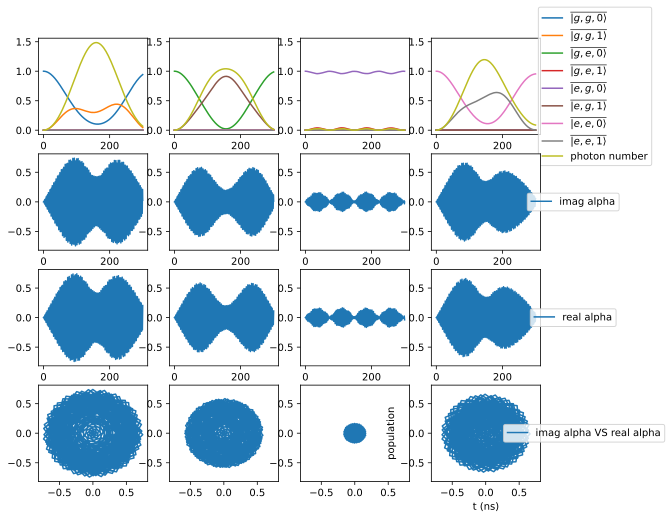

In [18]:
dominant_freq = w_d
nlevels = len(results)
dictionary = {0: 'g', 1: 'e', 2: 'f', 3: 'h'}
fig, axes = plt.subplots(4, len(results), figsize=(9, 2*nlevels))
if type(dominant_freq) == float or type(dominant_freq) == np.float64:
    dominant_freq = [dominant_freq]*nlevels

for i in range(nlevels):
    for idx, res in zip(dressed_idxs, results[i].expect):
        product_state = product_states[dressed_idxs.index(idx)]
        q1_state = dictionary[product_state[0]]
        q2_state = dictionary[product_state[1]]
        resonator_state = product_state[2]
        axes[0][i].plot(tlist, res, label=r"$\overline{|%s\rangle}$" % (str(",".join([q1_state,q2_state,str(resonator_state)]))))
    
    alpha = results[i].expect[-2]*np.exp(-1j * 2 * np.pi * dominant_freq[i] * tlist)  
    real = alpha.real
    imag = alpha.imag
    axes[0][i].plot(tlist, results[i].expect[-1], label=r"photon number")
    axes[1][i].plot(tlist,imag , label=r"imag alpha")
    axes[2][i].plot(tlist, real, label=r"real alpha")
    axes[3][i].plot(-imag, real, label=r"imag alpha VS real alpha")

axes[0][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))
axes[1][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
axes[2][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
axes[3][nlevels-1].legend(loc='center', ncol=1, bbox_to_anchor=(1.4, 0.5))
plt.ylabel("population")
plt.xlabel("t (ns)")
for row in [0,1,2,3]:
    max_x_range,min_x_range,max_y_range,min_y_range = 0,0,0,0
    for col in range(nlevels):
        ymin, ymax = axes[row][col].get_ylim()
        xmin, xmax = axes[row][col].get_xlim()
        if ymax > max_y_range:
            max_y_range = ymax
        if ymin < min_y_range:
            min_y_range = ymin
        if xmax > max_x_range:
            max_x_range = xmax
        if xmin < min_x_range:
            min_x_range = xmin
    for col in range(nlevels):
        axes[row][col].set_ylim(min_y_range, max_y_range)
        axes[row][col].set_xlim(min_x_range,max_x_range)
# plt.yscale('log')
plt.show()